**Load and predict on experimental data**

In [78]:
from utils.detect_and_trace.download import download_file_from_google_drive
import deeplay as dl
import torch
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
model_path = 'saved_models\lodestar3d_example.pth'

In [80]:
from utils.CNN_model import CNN
model = CNN()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**Instantiate lodestar class to use as predictor**

In [81]:
lodestar_predictor = dl.LodeSTAR(model = model, num_outputs = 3)

**Create data folder if it does not exist and download data to predict on**

In [82]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# download 300nm data
#TODO: dowload 300nm.npy from google drive to data/300nm.npy

# download 500nm data
#TODO: dowload 500nm.npy from google drive to data/500nm.npy


In [83]:
data_300nm = np.load('data/300nm.npy')
data_500nm = np.load('data/500nm.npy')

print(f'300nm.py shape: {data_300nm.shape}')
print(f'500nm.py shape: {data_500nm.shape}')

nr_frames = data_300nm.shape[0]
x_size = data_300nm.shape[1]
y_size = data_300nm.shape[2]

300nm.py shape: (50, 800, 750)
500nm.py shape: (50, 800, 750)


**Get predictions for all loades frames**

In [84]:
def predict_coordinates(data, steps = 5):
    if data.shape[0] % steps != 0:
        raise ValueError(f"Number of frames must be divisible by steps. {data.shape[0]} % {steps} != 0")
    
    predictions = []
    for i in range(0, nr_frames, steps):
        current_images = data[i:i+steps, :, :]
        current_images = torch.tensor(current_images).unsqueeze(1).type(torch.float32)*4
        print(f"Predicting frame {i} to {i+steps} out of total {nr_frames}...", end='\r')
        predictions.append(lodestar_predictor.detect(current_images, cutoff=0.97))
    
    print('\nRefactoring predictions...')
    new_predictions = []
    for prediction in predictions:
        for frame in prediction:
            new_frame = []
            for coordinates in frame:
                x_pred = coordinates[1] + y_size//2
                y_pred = coordinates[0] + x_size//2
                z_pred = coordinates[2]
                new_frame.append([x_pred, y_pred, z_pred])
            new_predictions.append(new_frame)

    print(f'\nPredictions for {nr_frames} frames done!')
    return new_predictions

predictions_300nm = predict_coordinates(data_300nm)


Predicting frame 45 to 50 out of total 50...
Refactoring predictions...

Predictions for 50 frames done!


**Create dataframe of the x and y coordinates to be used with MAGIK to create trajectories**

In [85]:
def get_magik_df(refactored_detections, time_interval, **kwargs):
    data_dict = {'centroid-0': [], 'centroid-1': [], 'frame': [], 'label': [], 'set': [], 'solution': []}
    for t in range(*time_interval):
        detections = refactored_detections[t]
        data_dict['centroid-0'] += [pos[0] for pos in detections]
        data_dict['centroid-1'] += [pos[1] for pos in detections]
        data_dict['frame'] += [t]*len(detections)
        data_dict['label'] += [0]*len(detections)
        data_dict['set'] += [0]*len(detections)
        data_dict['solution'] += [0]*len(detections)
    df = pd.DataFrame.from_dict(data_dict)
    return df

df_300nm = get_magik_df(predictions_300nm, (0, nr_frames))

**Create MAGIK instance and load dataframe**

In [86]:
import sys
parent_dir = ".."
sys.path.append(parent_dir)

from train_and_trace2d.utils.MAGIK2D import MAGIK
magik = MAGIK(dataframe=df_300nm, weights_path=os.path.join(data_dir, 'MAGIK_weights.h5'), dataset=data_300nm)

**Detect particle trajectories with x and y coordinates**

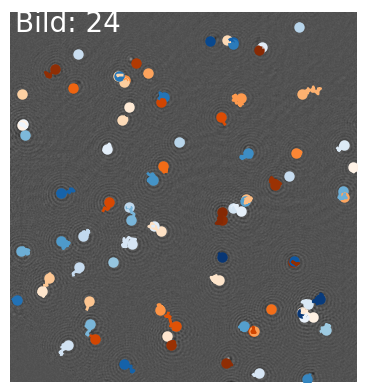

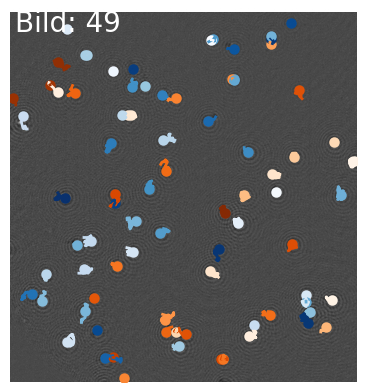

In [87]:
magik.set_dataset(data_300nm)
magik.detect(dataset_frames=(0,nr_frames), plot_every_nth=25)

**Extract nodes and trajectories and re-add the z-coordinate**

In [88]:

nodes = magik.nodes
traj = magik.traj
#filter out trajectories with less than 10 frames
traj = [[t,c] for (t,c) in magik.traj if len(t)>10]

def add_z_to_nodes(nodes, predictions):
    def is_close(a, b):
        return abs(a - b) < 0.00005

    new_nodes = np.hstack((nodes, np.zeros((nodes.shape[0], 1))))

    for frame_index in range(nr_frames):
        xyz_coords = predictions[frame_index]
        for xy in new_nodes:
            if int(xy[0]) == frame_index:
                for xyz in xyz_coords:
                    if is_close(xy[1]*y_size, xyz[0]) and is_close(xy[2]*x_size, xyz[1]):
                        xy[1] = xyz[0]
                        xy[2] = xyz[1]
                        xy[3] = xyz[2] 
    return new_nodes

new_nodes = add_z_to_nodes(nodes, predictions_300nm)

**Plot z against time**

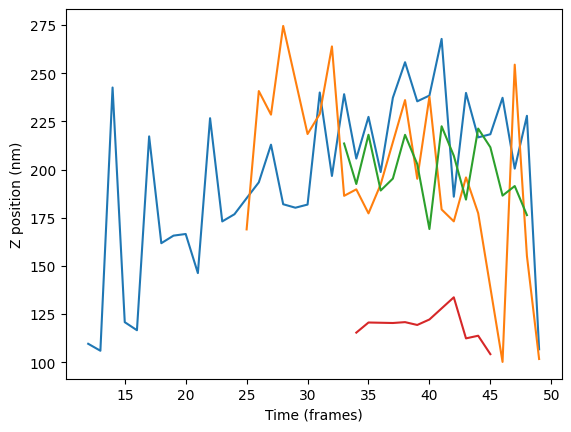

In [75]:
for (t,c) in traj:
    P_nodes = new_nodes[t]
    t = []
    z = []
    for i in range(1, len(P_nodes)):
        t.append(P_nodes[i][0])
        z.append(P_nodes[i][3]*65)
    if np.random.random() > 0.97:
        plt.plot(t, z)
    plt.xlabel('Time (frames)')
    plt.ylabel('Z position (nm)')

**Calculate diffusivites of the predicted trajectories**

In [89]:
def get_diffusivities(nodes, traj, pixel_size = 65, framerate = 110):
    TAMSD_list=[]
    TAMSD_z_list=[]
    
    for (t, c) in traj:
        TAMSD=0
        TAMSD_z=0
        trajectory = t
        particle_nodes = nodes[trajectory]
        for j in range(len(particle_nodes)-1):
            time_step = particle_nodes[j+1][0]-particle_nodes[j][0]
            deltax = (particle_nodes[j][1]-particle_nodes[j+1][1])*pixel_size/time_step
            deltay = (particle_nodes[j][2]-particle_nodes[j+1][2])*pixel_size/time_step
            deltaz = (particle_nodes[j][3]-particle_nodes[j+1][3])*pixel_size/time_step
            TAMSD += (deltax**2+deltay**2)/(len(trajectory)-1)
            TAMSD_z += deltaz**2/(len(trajectory)-1)
        TAMSD_list.append(TAMSD)
        TAMSD_z_list.append(TAMSD_z)
    TAMSD_mu_list = np.array(TAMSD_list)*10**(-6)
    TAMSD_z_mu_list = np.array(TAMSD_z_list)*10**(-6)
    
    delta_t = 1/framerate

    D_mu = TAMSD_mu_list/(4*delta_t)
    D_z_mu = TAMSD_z_mu_list/(2*delta_t)
    return D_mu, D_z_mu

def standard_deviation(diffusivities):
    Mean = np.mean(diffusivities)
    sigma = np.sqrt(np.sum((diffusivities-Mean)**2)/(len(diffusivities)-1))
    return sigma

def standard_error(diffusivities):
    return standard_deviation(diffusivities)/np.sqrt(len(diffusivities))

diffusivities, diffusivities_z = get_diffusivities(new_nodes, traj, pixel_size = 65, framerate = 110)

**Plot the diffusivities with mean, median, and standard error**

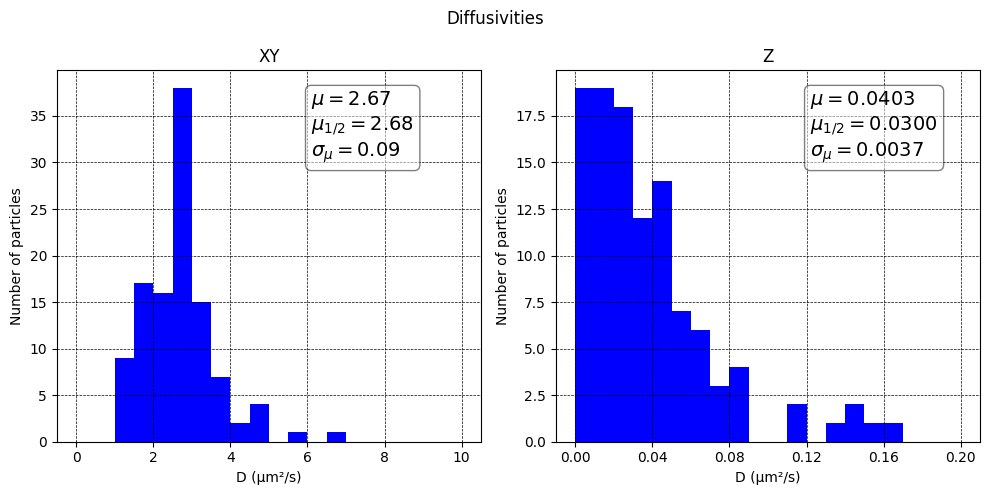

In [90]:
# create two subplots
bins = 20
maxrange = 10
maxrangez=0.2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Diffusivities')
ax1.grid(color='black', linestyle='--', linewidth=0.5)
ax1.hist(diffusivities, bins=bins, range=(0, maxrange), color='b')
ax1.set_title('XY')
ax1.set_xlabel('D (µm²/s)')
ax1.set_ylabel('Number of particles')
ax1.set_xticks(np.linspace(0, maxrange, int(bins/4)+1))
#add textbox
textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(diffusivities), ),
    r'$\mu_{1/2}=%.2f$' % np.sort(diffusivities)[len(diffusivities)//2],
    r'$\sigma_{\mu}=%.2f$' % (standard_error(diffusivities), )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.6, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2.grid(color='black', linestyle='--', linewidth=0.5)
ax2.hist(diffusivities_z, bins=bins, range=(0, maxrangez), color='b')
ax2.set_title('Z')
ax2.set_xlabel('D (µm²/s)')
ax2.set_ylabel('Number of particles')
ax2.set_xticks(np.linspace(0, maxrangez, int(bins/4)+1))
#add textbox
textstr = '\n'.join((
    r'$\mu=%.4f$' % (np.mean(diffusivities_z), ),
    r'$\mu_{1/2}=%.4f$' % np.sort(diffusivities_z)[len(diffusivities_z)//2],
    r'$\sigma_{\mu}=%.4f$' % (standard_error(diffusivities_z), )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(0.6, 0.95, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()

**Calculate covariances of trajectories**

In [91]:
def get_covariance(nodes, traj, pixel_size = 65, lagmax = 10):
    covx_matrix = []
    covy_matrix = []
    covz_matrix = []
    for (t, c) in traj:
        Nodes = nodes[t]
        covx_particle = []
        covy_particle = []
        covz_particle = []
        for lag in range(lagmax):
            covx = np.array([])
            covy = np.array([])
            covz = np.array([])
            for j in range(len(Nodes)-1-lag):
                Tidsstegn = Nodes[j+1][0]-Nodes[j][0]
                Tidsstegnj = Nodes[j+1+lag][0]-Nodes[j+lag][0]

                Steg_xn  = (Nodes[j+1][1]-Nodes[j][1])/Tidsstegn
                Steg_xnj = (Nodes[j+1+lag][1]-Nodes[j+lag][1])/Tidsstegnj

                covx = np.append(covx, (Steg_xn*Steg_xnj)*(pixel_size*10**(-3))**2)

                Steg_yn  = (Nodes[j+1][2]-Nodes[j][2])/Tidsstegn
                Steg_ynj = (Nodes[j+1+lag][2]-Nodes[j+lag][2])/Tidsstegnj

                covy = np.append(covy, (Steg_yn*Steg_ynj)*(pixel_size*10**(-3))**2)
                
                Steg_zn  = (Nodes[j+1][3]-Nodes[j][3])/Tidsstegn
                Steg_znj = (Nodes[j+1+lag][3]-Nodes[j+lag][3])/Tidsstegnj

                covz = np.append(covz, (Steg_zn*Steg_znj)*(pixel_size*10**(-3))**2)

            covxapp = np.mean(covx)
            covyapp = np.mean(covy)
            covzapp = np.mean(covz)

            covx_particle.append(covxapp)
            covy_particle.append(covyapp)
            covz_particle.append(covzapp)
        covx_matrix.append(covx_particle)
        covy_matrix.append(covy_particle)
        covz_matrix.append(covz_particle)
    
    Errorx = np.sqrt(np.sum((np.sum(covx_matrix, axis=0)/len(covx_matrix)-covx_matrix)**2, axis=0)/((len(covx_matrix)-1)*len(covx_matrix)))
    Errory = np.sqrt(np.sum((np.sum(covy_matrix, axis=0)/len(covy_matrix)-covy_matrix)**2, axis=0)/((len(covy_matrix)-1)*len(covx_matrix)))
    Errorz = np.sqrt(np.sum((np.sum(covz_matrix, axis=0)/len(covz_matrix)-covz_matrix)**2, axis=0)/((len(covz_matrix)-1)*len(covx_matrix)))

    covxAvg = np.sum(covx_matrix, axis=0)/len(covx_matrix)
    covyAvg = np.sum(covy_matrix, axis=0)/len(covy_matrix)
    covzAvg = np.sum(covz_matrix, axis=0)/len(covz_matrix)
    return covxAvg, covyAvg, covzAvg, Errorx, Errory, Errorz

lagmax = 10
covxAvg, covyAvg, covzAvg, Errorx, Errory, Errorz = get_covariance(nodes=new_nodes, traj=traj, lagmax=lagmax)


**Plot covariances**

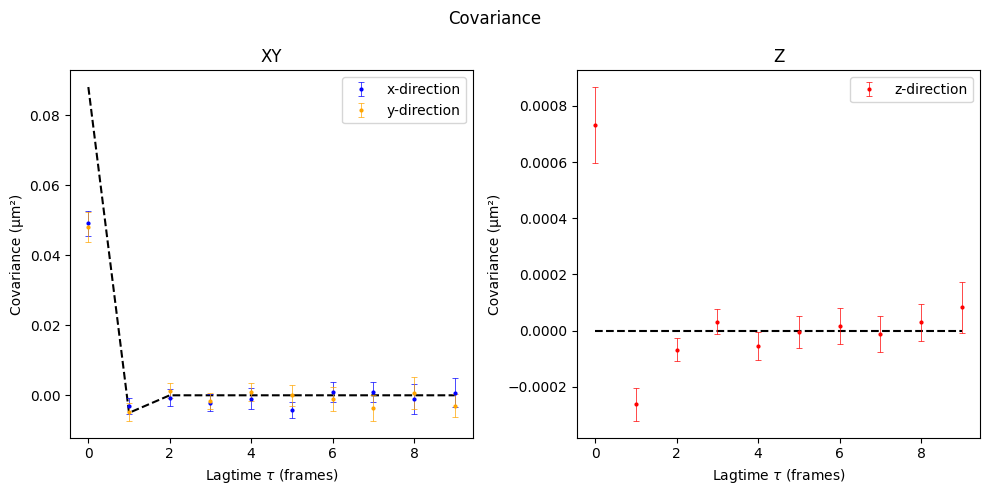

In [92]:
delta_t = 1/110
laglist = np.arange(0, lagmax, 1)

#calculate the expected covariance
kb = 1.380649*10**(-23)
T = 294
eta = 8.9*10**(-4)
r = 50*10**(-9)
D=kb*T/(6*np.pi*eta*r)
theory = np.zeros(len(laglist))
theory[0] = 2*D*delta_t*10**(12)
theory[1] = -0.005 #arbitrary value, dependent on camera settings

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Covariance')

ax1.plot(laglist, theory, color='black', linestyle='--')
ax1.errorbar(laglist, covxAvg, Errorx*2, linestyle='', color='blue', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='x-direction')
ax1.errorbar(laglist, covyAvg, Errory*2, linestyle='', color='orange', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='y-direction')
ax1.set_xlabel(r'Lagtime $\tau$ (frames)')
ax1.set_ylabel(r'Covariance (µm²)')
ax1.set_title('XY')
ax1.legend()

ax2.plot(laglist, np.zeros(len(laglist)), color='black', linestyle='--')
ax2.errorbar(laglist, covzAvg, Errorz*2, linestyle='', color='red', elinewidth=0.5, capthick=0.5, capsize=2, marker='o', markersize=2, label='z-direction')
ax2.set_xlabel(r'Lagtime $\tau$ (frames)')
ax2.set_ylabel(r'Covariance (µm²)')
ax2.set_title('Z')
ax2.legend()

plt.tight_layout()


